## Enhancing Pneumonia Detection: A Comparative Study of CNN, VGG16, and ResNet50 Models

Team: Roop Sagar Mangineni, Ankit Jyothish, Lakshmi Narayana Aditya Akilesh Mantha



## Importing Libraries

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import random
import zipfile
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

# improve visualization
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [70]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Dataset and converting as grayscale

In [3]:
dir_train = '/content/drive/MyDrive/UROP/chest_xray/chest_xray/train'
dir_valid = '/content/drive/MyDrive/UROP/chest_xray/chest_xray/val'
dir_test = '/content/drive/MyDrive/UROP/chest_xray/chest_xray/test'

labels = ['NORMAL', 'PNEUMONIA'] # creating the labels
dataset_train = []
dataset_valid = []
dataset_test = []

def load_train_dataset(): # creating function to load dataset_train
  for label in labels:
    path = os.path.join(dir_train, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_train.append([resize_img, class_num])
      except Exception as e:
        pass

def load_valid_dataset(): # function to load dataset_valid
  for label in labels:
    path = os.path.join(dir_valid, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_valid.append([resize_img, class_num])
      except Exception as e:
        pass

def load_test_dataset(): # function to load dataset_test
  for label in labels:
    path = os.path.join(dir_test, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_test.append([resize_img, class_num])
      except Exception as e:
        pass

load_train_dataset()
load_valid_dataset()
load_test_dataset()

### Train-Test Split

In [4]:

x_train_ini = []
y_train = []

x_valid_ini = []
y_valid = []

x_test_ini = []
y_test = []

for features, label in dataset_train:
  x_train_ini.append(features)
  y_train.append(label)

for features, label in dataset_valid:
  x_valid_ini.append(features)
  y_valid.append(label)

for features, label in dataset_test:
  x_test_ini.append(features)
  y_test.append(label)

Text(0.5, 0, 'PNEUMONIA')

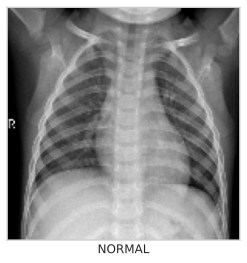

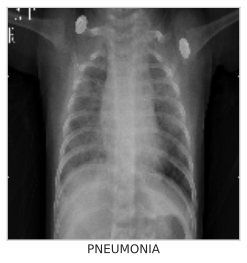

In [6]:
# Healthy Lung
plt.figure(figsize=(4,4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset_train[0][0], cmap='gray')
plt.xlabel(labels[dataset_train[0][1]])

# lung with pneumonia
plt.figure(figsize=(4,4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset_train[-1][0], cmap='gray')
plt.xlabel(labels[dataset_train[-1][1]])

### Image Normalisation

In [7]:

# function to normalize the pixels
f_norm = lambda x: (np.array(x) / 255.0).astype('float32')

x_train = f_norm(x_train_ini)
x_valid = f_norm(x_valid_ini)
x_test = f_norm(x_test_ini)

# shape:
print('Shape x_train: {} \nShape x_valid: {} \nShape x_test: {}'.format(
    x_train.shape, x_valid.shape, x_test.shape))

Shape x_train: (5216, 150, 150) 
Shape x_valid: (16, 150, 150) 
Shape x_test: (624, 150, 150)


### Image Resizing

In [8]:
# resize function
f_resize = lambda x: np.array(x).reshape(-1, 150, 150, 1)

x_train = f_resize(x_train)
x_valid = f_resize(x_valid)
x_test = f_resize(x_test)

# let's print the shape again to check the changes
print('Shape x_train: {} \nShape x_valid: {} \nShape x_test: {}'.format(
    x_train.shape, x_valid.shape, x_test.shape))

Shape x_train: (5216, 150, 150, 1) 
Shape x_valid: (16, 150, 150, 1) 
Shape x_test: (624, 150, 150, 1)


In [9]:

# function to convert to array
fc = lambda x: np.array(x)

x_train = fc(x_train)
y_train = fc(y_train)
x_valid = fc(x_valid)
y_valid = fc(y_valid)
x_test = fc(x_test)
y_test = fc(y_test)

### Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)


train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(dir_train, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(dir_valid, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(dir_test, class_mode = "binary", batch_size = 16, target_size = (224, 224))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
train_datagen.fit(x_test)

## CNN

In [27]:

model = keras.models.Sequential()

#convolutional neural networks - CNNs
model.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (150, 150, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())

#fully connected layer
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 37, 37, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 128)      

In [28]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [29]:

history = model.fit(
x_train, y_train, batch_size=32, shuffle=True,epochs=10, validation_data = (x_valid, y_valid), callbacks=[early_stopping_callbacks])

Epoch 1/10
163/163 [==============================] - 82s 492ms/step - loss: 0.4068 - accuracy: 0.8200 - val_loss: 1.2712 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 80s 493ms/step - loss: 0.1203 - accuracy: 0.9569 - val_loss: 0.2539 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 81s 497ms/step - loss: 0.0913 - accuracy: 0.9686 - val_loss: 0.3231 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 83s 508ms/step - loss: 0.0830 - accuracy: 0.9707 - val_loss: 0.1439 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 84s 518ms/step - loss: 0.0755 - accuracy: 0.9724 - val_loss: 0.1294 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 84s 515ms/step - loss: 0.0619 - accuracy: 0.9781 - val_loss: 0.6554 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 82s 503ms/step - loss: 0.0617 - accuracy: 0.9783 - val_loss: 0.0947 - val_ac

In [31]:
model.input, model.output

(<KerasTensor: shape=(None, 150, 150, 1) dtype=float32 (created by layer 'conv2d_12_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_15')>)

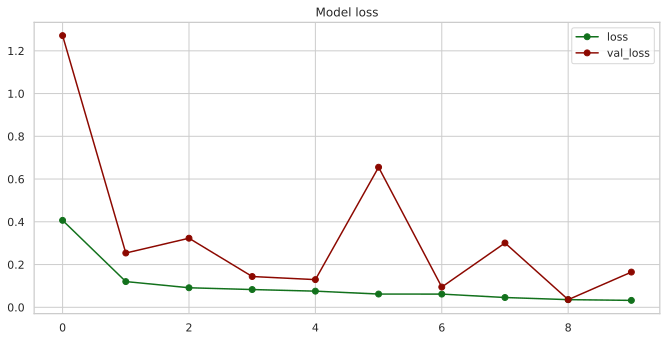

In [32]:

plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

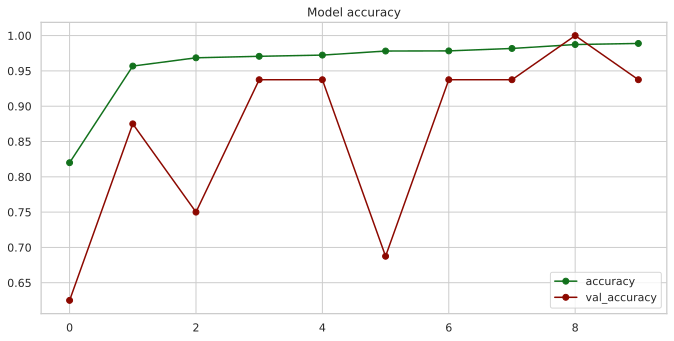

In [33]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [35]:

scores = model.evaluate(x_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 72.44%


In [36]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Testing Score')
    plt.plot(epochs, val_accuracy, 'r', label='validation Score')
    plt.title('Scores')
    plt.legend()
    plt.show()

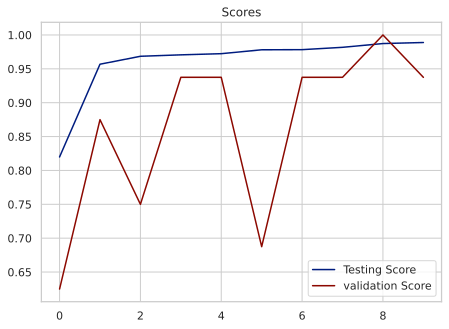

In [37]:
plot_scores(history)

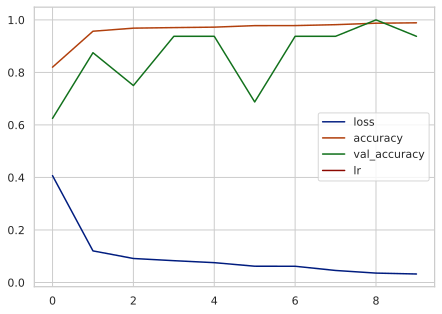

In [38]:
# pd.DataFrame(history.history, columns=["loss", "accuracy", "val_accuracy", "lr"]).plot()
# plt.show()
pd.DataFrame(history.history, columns=["loss", "accuracy", "val_accuracy", "lr"]).plot()
plt.show()

## Model Prediction

In [40]:
img = '/content/drive/MyDrive/UROP/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
resize_img = cv2.resize(img_array, (150,150))

resize_img = np.array(resize_img) / 255.0
resize_img = f_resize(resize_img)

if(model.predict(resize_img)>=0.50):
  print("Lungs with Pneumonia")
else:
  print("Lungs without Pneumonia")


1/1 [==============================] - 0s 156ms/step
Lungs without Pneumonia


In [41]:
img = '/content/drive/MyDrive/UROP/chest_xray/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'
img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
resize_img = cv2.resize(img_array, (150,150))

resize_img = np.array(resize_img) / 255.0
resize_img = f_resize(resize_img)

if(model.predict(resize_img)>=0.50):
  print("Lungs with Pneumonia")
else:
  print("Lungs without Pneumonia")

1/1 [==============================] - 0s 30ms/step
Lungs with Pneumonia


## VGG16 Model

In [42]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np


base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (150, 150, 3), pooling = "max",
                    classes = 2)

58889256/58889256 [==============================] - 3s 0us/step


In [43]:

# Convert grayscale images to RGB and resize to (150, 150)
x_train_rgb = np.repeat(x_train, 3, -1)
x_valid_rgb = np.repeat(x_valid, 3, -1)

# Resize to (150, 150)
x_train_resized = [cv2.resize(image, (150, 150)) for image in x_train_rgb]
x_valid_resized = [cv2.resize(image, (150, 150)) for image in x_valid_rgb]

# Convert to numpy arrays
x_train_vgg = np.array(x_train_resized)
x_valid_vgg = np.array(x_valid_resized)

# Ensure the input shape matches VGG16 requirements
print('Shape x_train_vgg:', x_train_vgg.shape)
print('Shape x_valid_vgg:', x_valid_vgg.shape)


base_model1.summary()

model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation="relu"))
model2.add(Dense(64, activation="relu"))
model2.add(Dense(32, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

# Freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history2 = model2.fit(
    x_train_vgg, y_train, batch_size=32, shuffle=True, epochs=10,
    validation_data=(x_valid_vgg, y_valid), callbacks=[early_stopping_callbacks]
)


base_model1 = VGG16(include_top=False, weights="imagenet", input_shape=(150, 150, 3), pooling="max")




Shape x_train_vgg: (5216, 150, 150, 3)
Shape x_valid_vgg: (16, 150, 150, 3)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                   

In [44]:
model2.input, model2.output

(<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'vgg16_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_19')>)

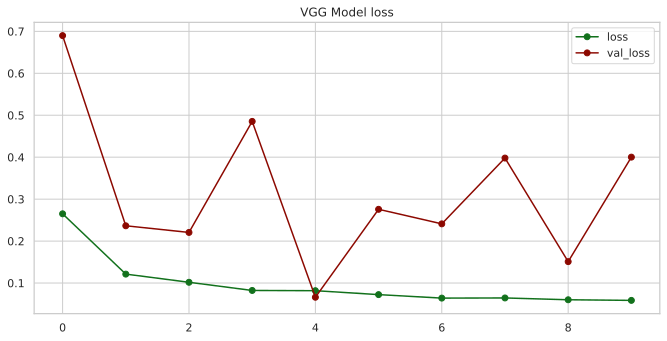

In [45]:
plt.figure(figsize = (10, 5))
plt.title("VGG Model loss")
plt.plot(history2.history["loss"], "go-")
plt.plot(history2.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

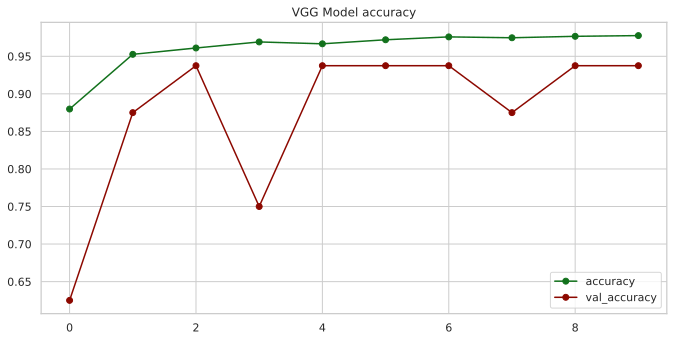

In [46]:
plt.figure(figsize = (10, 5))
plt.title("VGG Model accuracy")

plt.plot(history2.history["accuracy"], "go-")
plt.plot(history2.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [47]:
test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")


39/50 [======================>.......] - ETA: 24s - loss: 2.7151 - accuracy: 0.6490

50/50 [==============================] - 89s 2s/step - loss: 2.7151 - accuracy: 0.6490
The testing accuracy is:  64.90384340286255 %


In [48]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Testing Score')
    plt.plot(epochs, val_accuracy, 'r', label='validation Score')
    plt.title('Scores')
    plt.legend()
    plt.show()

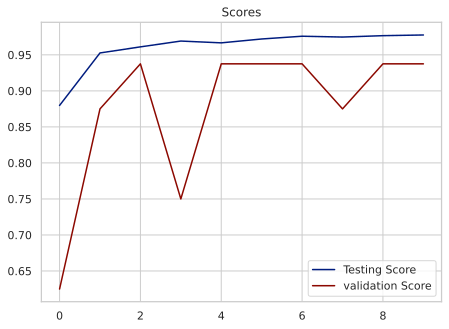

In [49]:
plot_scores(history2)

## Training ResNet50

In [50]:
base_model2 = tf.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (150, 150, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 4s 0us/step


In [51]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [52]:

history3 = model3.fit(
    x_train_vgg, y_train, batch_size=32, shuffle=True, epochs=10,
    validation_data=(x_valid_vgg, y_valid), callbacks=[early_stopping_callbacks]
)

Epoch 1/10
163/163 [==============================] - 102s 602ms/step - loss: 0.1899 - accuracy: 0.9329 - val_loss: 0.6524 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 96s 591ms/step - loss: 0.1004 - accuracy: 0.9613 - val_loss: 1.8586 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 98s 601ms/step - loss: 0.0679 - accuracy: 0.9751 - val_loss: 1.7653 - val_accuracy: 0.5625
Epoch 4/10
163/163 [==============================] - 98s 600ms/step - loss: 0.0635 - accuracy: 0.9758 - val_loss: 0.4509 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 97s 592ms/step - loss: 0.0594 - accuracy: 0.9766 - val_loss: 0.7015 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 99s 605ms/step - loss: 0.0352 - accuracy: 0.9866 - val_loss: 1.0288 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 98s 601ms/step - loss: 0.0411 - accuracy: 0.9839 - val_loss: 0.2488 - val_a

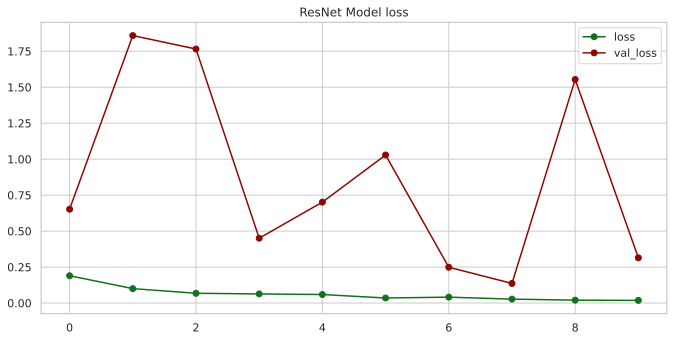

In [53]:
plt.figure(figsize = (10, 5))
plt.title("ResNet Model loss")
plt.plot(history3.history["loss"], "go-")
plt.plot(history3.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

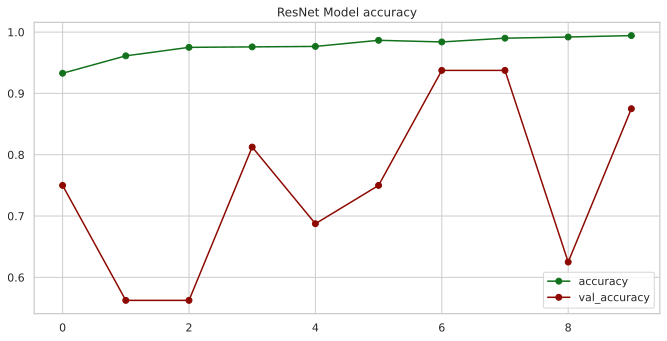

In [54]:
plt.figure(figsize = (10, 5))
plt.title("ResNet Model accuracy")

plt.plot(history3.history["accuracy"], "go-")
plt.plot(history3.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [55]:
test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")


39/50 [======================>.......] - ETA: 7s - loss: 1.3525 - accuracy: 0.7885

50/50 [==============================] - 28s 525ms/step - loss: 1.3525 - accuracy: 0.7885
The testing accuracy is:  78.84615659713745 %


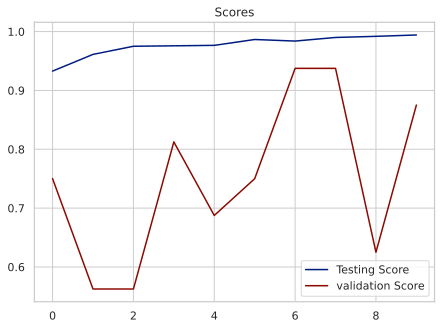

In [56]:
plot_scores(history3)

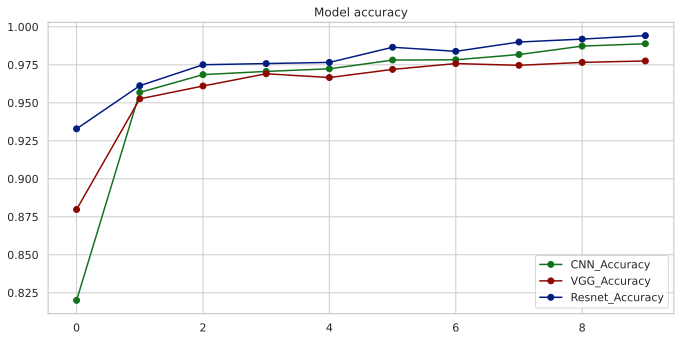

In [57]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history2.history["accuracy"], "ro-")
plt.plot(history3.history["accuracy"], "bo-")
plt.legend(["CNN_Accuracy", "VGG_Accuracy","Resnet_Accuracy"])
plt.show()

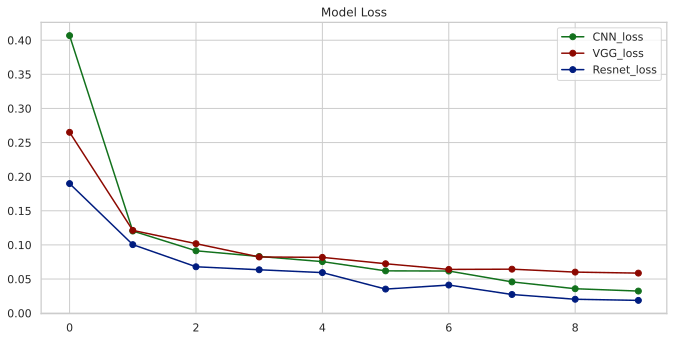

In [58]:
plt.figure(figsize = (10, 5))
plt.title("Model Loss")

plt.plot(history.history["loss"], "go-")
plt.plot(history2.history["loss"], "ro-")
plt.plot(history3.history["loss"], "bo-")
plt.legend(["CNN_loss", "VGG_loss","Resnet_loss"])
plt.show()

In [59]:
test_dir = "/content/drive/MyDrive/UROP/chest_xray/chest_xray/test"
test_data, test_labels = [], []

In [60]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (150, 150))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

VGG Confusion Matrix : 

20/20 [==============================] - 38s 2s/step


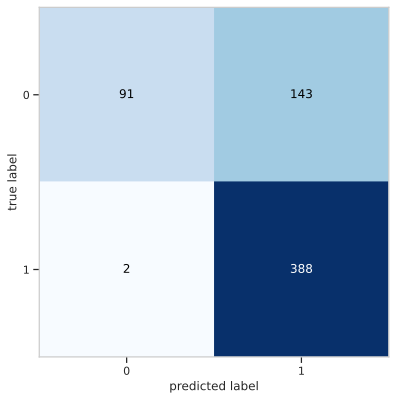

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

print("VGG Confusion Matrix : \n")

predictions = model2.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [66]:
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 76.76282051282051%
Precision: 73.06967984934086%
Recall: 99.48717948717949%
F1-score: 84.25624321389793


ResNet Confusion Matrix : 

20/20 [==============================] - 14s 642ms/step


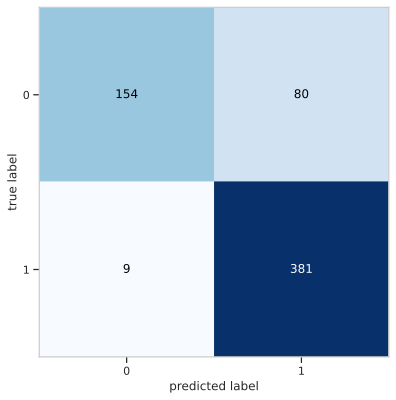

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

print("ResNet Confusion Matrix : \n")

predictions = model3.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [68]:
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 85.73717948717949%
Precision: 82.646420824295%
Recall: 97.6923076923077%
F1-score: 89.54171562867215
